In [1]:
%matplotlib inline

import os
import numpy as np
import tensorflow_probability as tfp
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

/home/ubuntujan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntujan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntujan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntujan/anaconda3/lib/python3.7/site-packages/tensorflow/python/f

Instructions for updating:
non-resource variables are not supported in the long term


In [7]:
data_raw = np.load("../data/FireEvac_train_set.npy")
data_test = np.load("../data/FireEvac_test_set.npy")

In [2]:
data_raw.shape

(3000, 2)

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((data_raw[:,0], data_raw[:,1]))
test_dataset = tf.data.Dataset.from_tensor_slices((data_test[:,0], data_raw[:,1]))

ValueError: Dimensions 600 and 3000 are not compatible

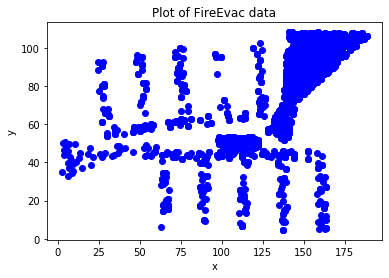

In [3]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(data_raw[:,0], data_raw[:,1], color = 'b')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of FireEvac data')
plt.show()

In [4]:
class VAE(object):
    def __init__(self, learning_rate=0.001, decoder_std = 0.5, latent_dim=2):
        #set hyperparameters
        self.x = tf.placeholder(dtype=tf.float32, shape=[None, input_size])
        self.learning_rate = learning_rate
        self.decoder_std = decoder_std
        self.latent_dim = latent_dim
        
        self.build()
        
        #Initialize parameters
        self.sess = tf.Session()
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
    def encoder(self, x):
        x1 = tf.layers.dense(x, 256, activation=tf.nn.relu)
        x2 = tf.layers.dense(x1, 256, activation=tf.nn.relu)
        self.mu = tf.layers.dense(x2, self.latent_dim)
        self.scale = tf.layers.dense(x2, self.latent_dim)
        std = tf.sqrt(1e-5 + tf.exp(self.scale))
        return self.mu, std
    
    def prior(self):
        loc = tf.zeros(self.latent_dim)
        scale = tf.ones(self.latent_dim)
        return tfd.MultivariateNormalDiag(loc, scale)
    
    def decoder(self, z, input_size=2): #input_size=2
        z1 = tf.layers.dense(z, 256, activation=tf.nn.relu)
        z2 = tf.layers.dense(z1, 256, activation=tf.nn.relu)
        mu = tf.layers.dense(z2, input_size)
        decoder_std = tf.sqrt(1e-5 + tf.exp(tf.layers.dense(z2, input_size, tf.nn.softplus)))
        return mu, decoder_std

    
    def build(self):
        
        self.encoder = tf.make_template('encoder', self.encoder)
        self.decoder = tf.make_template('decoder', self.decoder)
        
        #encode an image into the distribution of latent space
        self.encoder_mu, self.encoder_std = self.encoder(self.x)

        #sample by reparametrisation
        eps = tf.random_normal(shape=[tf.shape(self.x)[0], self.latent_dim], mean=0.0, stddev=1.0, dtype=tf.float32)
        self.z = self.encoder_mu + self.encoder_std*eps

        #decode latent vector z
        self.decoder_mu, self.decoder_std = self.decoder(self.z)

        
        self.posterior = tfd.MultivariateNormalDiag(self.encoder_mu, self.encoder_std)
        prior = self.prior()
        
        decoder_samp_mu, decoder_samp_std = self.decoder(prior.sample(15))
        
        self.samples = tfd.Independent(tfd.MultivariateNormalDiag(decoder_samp_mu, decoder_samp_std)).mean()
        
        #reconstruction loss
        self.likelihood = tfd.Independent(tfd.MultivariateNormalDiag(self.decoder_mu, self.decoder_std)).log_prob(self.x)

        
        #KL divergence loss
        self.divergence = tfd.kl_divergence(self.posterior, prior)
        self.elbo = tf.reduce_mean(self.likelihood - self.divergence, axis=0)
        self.optimize = tf.train.AdamOptimizer(self.learning_rate).minimize(-self.elbo)
        return

    def run(self, x):
        self.sess.run(self.optimize, feed_dict={self.x: x})
        return
    
    
    def plot_latent(self, z=[], labels=[]):
        plt.figure(figsize=(5, 4))
        plt.scatter(z[:, 0], z[:, 1], c=labels, s=20)
        plt.xlim(z.min() - .1, z.max() + .1)
        plt.ylim(z.min() - .1, z.max() + .1)
        plt.grid()
        
    def plot_reconstruction(self, x, mnist, h=1, w=1): # change dimensions here again
        x_reconstructed = x
        n = 15
        I_reconstructed = np.empty((h*1, 2*w*n))
        for i in range(n):
            x = np.concatenate(
                (x_reconstructed[i, :].reshape(h, w), 
                mnist[i, :].reshape(h, w)),
                axis=1
            )
            I_reconstructed[0:h, i*2*w:(i+1)*2*w] = x
        plt.figure(figsize=(10, 20))
        plt.imshow(I_reconstructed, cmap='gray')
    
    def plot_samples(self, ax=[], samples=[]):
        for index, sample in enumerate(samples):
            ax[index].imshow(sample, cmap='gray')
            ax[index].axis('off')

In [5]:
model = VAE(learning_rate=0.001, decoder_std=0.5, latent_dim=2)
fig, ax = plt.subplots(nrows=5, ncols=15, figsize=(20, 20))
i = 0
stop_epoch = 0
elbo = []

for epoch in range(epochs):
    feed = {model.x: data_raw} #change data here
    #likelihood = model.sess.run([model.likelihood], feed)
    #print('likelihood', likelihood)
    test_elbo, test_z, test_samples, test_decoder_mu =  model.sess.run(
        [model.elbo, model.z, model.samples, model.decoder_mu], feed)
    elbo.append(-test_elbo)
    print('Epoch', epoch, 'elbo', -test_elbo)
    
    
    #set stop training criteria
    if epoch == 0:
        min_elbo = -test_elbo
    elif -test_elbo < min_elbo:
        min_elbo = -test_elbo
        stop_epoch = 0
    elif -test_elbo > min_elbo:
        stop_epoch+=1
    
    if stop_epoch > 10:
        print('stop at epoch', epoch)
        model.plot_latent(test_z, mnist2.test.labels)
        model.plot_reconstruction(test_decoder_mu,mnist2.test.images)
        ax[i, 0].set_ylabel('Epoch {}'.format(epoch))
        test_samples = test_samples.reshape([-1, 28, 28])
        model.plot_samples(ax[i, :], test_samples)
        break
    
    
    #plot latent representation    
    if epoch in [0, 4, 24, 49]:    
        model.plot_latent(test_z, mnist2.test.labels)
        model.plot_reconstruction(test_decoder_mu,mnist2.test.images)
        ax[i, 0].set_ylabel('Epoch {}'.format(epoch))
        test_samples = test_samples.reshape([-1, 28, 28])
        model.plot_samples(ax[i, :], test_samples)
        i+=1
        
    #training step 
    for _ in range(mnist2.train.num_examples // batch_size):
        batch = mnist2.train.next_batch(batch_size)[0]
        model.run(batch)
        
print('train stop!')

NameError: name 'input_size' is not defined